# Simple aperture photometry

* stack a few raw images
* subtract median
* find peaks and sort
* get n brightest peaks
* save centroid location (smaller box)
* crop image location and get new peak locations
* do photometry
* measure background
* measure fwhm

## References

* HAT-P-14 b [(Fukui+16a))](http://iopscience.iop.org/article/10.3847/0004-637X/819/1/27/pdf)
* K2-3d [(Fukui+16b)](http://iopscience.iop.org/article/10.3847/0004-6256/152/6/171) 

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'moscatel'

In [3]:
import os
from glob import glob
import getpass
from tqdm import tqdm
import warnings

filedir='/home/'+getpass.getuser()+'/data/transit/hatp44_data'
file_list = glob(os.path.join(filedir,'*.fits'))
file_list.sort()
len(file_list)

1456

In [4]:
from moscatel import utils

bands = utils.get_band_list(file_list);

100%|██████████| 1456/1456 [00:04<00:00, 349.40it/s]

g-band: 376 frames
r-band: 704 frames
z_s-band: 376 frames


## Stack (some) raw images

In [5]:
from moscatel import utils

stacked_images = []
for key in sorted(bands.keys()):
    stacked_images.append(utils.stack_raw_images(bands[key], skip_every=10))

 21%|██        | 15/71 [00:00<00:00, 147.46it/s]

number of stacked raw images=38


 45%|████▍     | 17/38 [00:00<00:00, 163.06it/s]

number of stacked raw images=71


100%|██████████| 38/38 [00:00<00:00, 154.71it/s]


number of stacked raw images=38


## Detect point sources

In [6]:
from moscatel import phot

sources = []

for idx, img in enumerate(stacked_images):
    sources.append(phot.get_sources(img, num_stars=10))

note that star 1 and 2 is different in g-band.

## aperture photometry

[`photutils.aperture`](http://photutils.readthedocs.io/en/latest/photutils/aperture.html)


for masking, [see](http://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array)


try `aperture_photometry( ... ,method='subpixel', subpixels=5)` for subpixel accucacy.

## try for g-band with 3 stars and 2 aperture radii

In [72]:
import importlib, moscatel
importlib.reload(moscatel.phot)

<module 'moscatel.phot' from '/home/Jerome/github/moscatel/notebook/moscatel/phot.py'>

In [8]:
from moscatel import phot

centroids_g = list(zip(sources[0]['xcentroid'],sources[0]['ycentroid']))
centroids_r = list(zip(sources[1]['xcentroid'],sources[1]['ycentroid']))
centroids_z = list(zip(sources[2]['xcentroid'],sources[2]['ycentroid']))
centroids = [centroids_g,centroids_r,centroids_z]

band_idx = 0 #g,r,z
nstars=3 # or specify as centroids[band_idx][idx0,idx1,...]
skip_every=1
radii =[10,15,20]
box_size = 40

tables=phot.make_lightcurve(bands['g'], centroids[band_idx][:nstars], 
                       aperture_radii=radii, skip_every=1, box_size=40, 
                       r_in=20, r_out=25);

  0%|          | 0/376 [00:00<?, ?it/s]

performing aperture photometry on 3 stars


---------star index: 0---------
initial centroid: (702.82130824352134, 303.33911260721948)


  1%|          | 2/376 [00:00<00:34, 10.80it/s]


---------star index: 1---------
initial centroid: (914.91854174262744, 263.88871354492659)


  1%|          | 2/376 [00:00<00:33, 11.00it/s]


---------star index: 2---------
initial centroid: (707.37585836472431, 757.73533211472306)


100%|██████████| 376/376 [00:43<00:00,  7.81it/s]

---------Done---------


In [9]:
#save as separate csv's per star
dfs=utils.parse_and_save_tables(tables, band_idx)

saved:
data/phot_gband_star0.csv
saved:
data/phot_gband_star1.csv
saved:
data/phot_gband_star2.csv


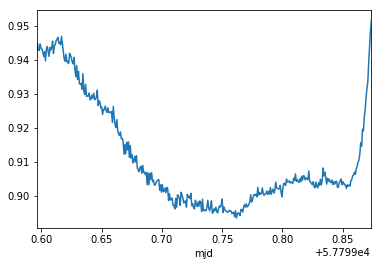

In [19]:
%matplotlib inline

param='aperture_sum_1'
t=dfs[1][param]
ref=dfs[0][param]

(t/ref).plot()

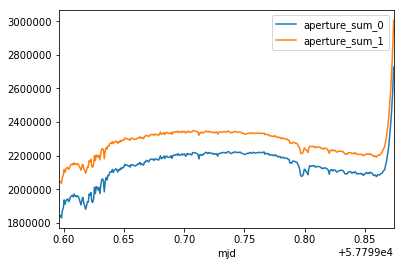

In [77]:
star_idx=0
params = 'aperture_sum_0,aperture_sum_1'.split(',')
dfs[star_idx][params].plot()

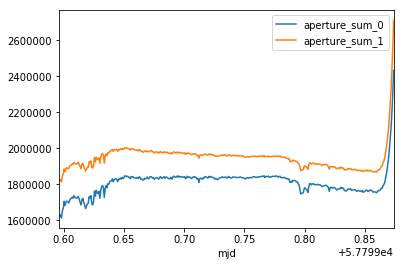

In [78]:
star_idx=1
dfs[star_idx][params].plot()

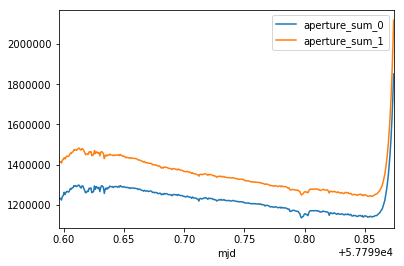

In [79]:
star_idx=2
dfs[star_idx][params].plot()

## try for r-band with 3 stars and 2 aperture radii

In [20]:
band_idx = 1 #g,r,z

band=sorted(bands.keys())
nstars=3 # or specify as centroids[band_idx][idx0,idx1,...]
skip_every=1
radii =[10,15,20]
box_size = 40

tables=phot.make_lightcurve(bands[band[band_idx]], centroids[band_idx][:nstars], 
                       aperture_radii=radii, skip_every=1, box_size=40, 
                       r_in=10, r_out=25);


  0%|          | 2/704 [00:00<01:04, 10.96it/s]

performing aperture photometry on 3 stars


---------star index: 0---------
initial centroid: (702.26231517542624, 300.98720542277374)


  0%|          | 2/704 [00:00<01:02, 11.19it/s]


---------star index: 1---------
initial centroid: (913.706802833859, 258.46971068697587)


  0%|          | 2/704 [00:00<01:07, 10.38it/s]


---------star index: 2---------
initial centroid: (713.03279888873192, 755.2944035162152)


100%|██████████| 704/704 [01:25<00:00,  7.64it/s]

---------Done---------


In [21]:
dfs=utils.parse_and_save_tables(tables, band_idx)

saved:
data/phot_rband_star0.csv
saved:
data/phot_rband_star1.csv
saved:
data/phot_rband_star2.csv


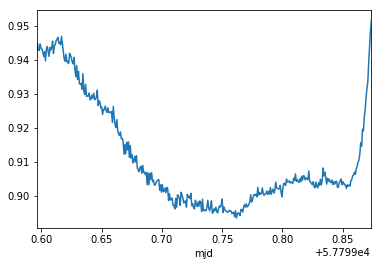

In [19]:
%matplotlib inline

param='aperture_sum_1'
t=dfs[1][param]
ref=dfs[0][param]

(t/ref).plot()

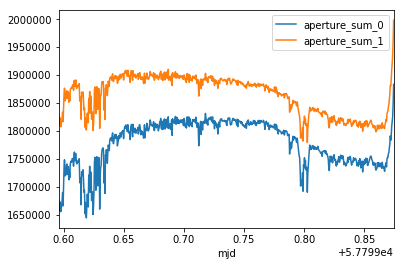

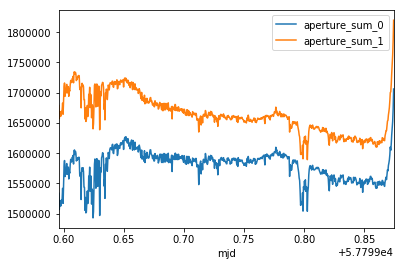

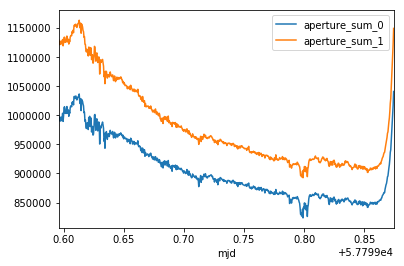

In [83]:
params = 'aperture_sum_0,aperture_sum_1'.split(',')

for i in range(nstars):
    dfs[i][params].plot()

## try for z-band with 3 stars and 2 aperture radii

In [84]:
band_idx = 2 #g,r,z

tables=phot.make_lightcurve(bands[band[band_idx]], centroids[band_idx][:nstars], 
                       aperture_radii=radii, skip_every=1, box_size=40, 
                       r_in=15, r_out=20);
dfs=utils.parse_and_save_tables(tables, band_idx)

  1%|          | 2/376 [00:00<00:34, 10.88it/s]

performing aperture photometry on 3 stars


---------star index: 0---------
initial centroid: (911.39188437197015, 246.12980190879145)


  1%|          | 2/376 [00:00<00:32, 11.42it/s]


---------star index: 1---------
initial centroid: (699.53750528700039, 286.07443110839995)


  0%|          | 0/376 [00:00<?, ?it/s]


---------star index: 2---------
initial centroid: (704.18187575311833, 740.5490320830886)


100%|██████████| 376/376 [00:47<00:00,  7.33it/s]


---------Done---------
saved:
data/phot_z_sband_star0.csv
saved:
data/phot_z_sband_star1.csv
saved:
data/phot_z_sband_star2.csv


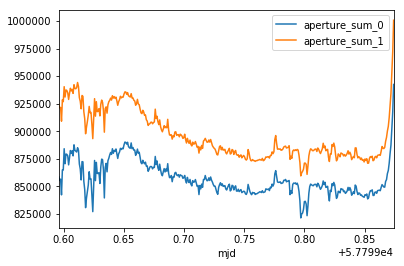

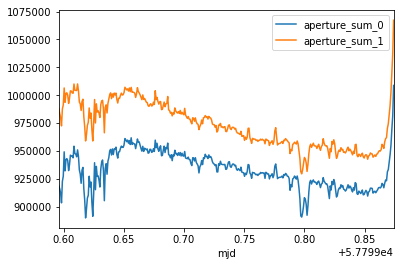

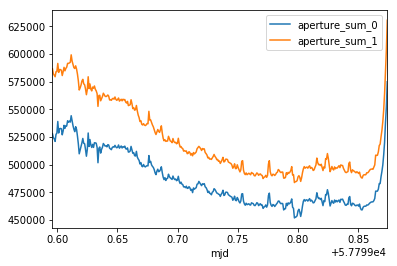

In [85]:
params = 'aperture_sum_0,aperture_sum_1'.split(',')

for i in range(nstars):
    dfs[i][params].plot()

It takes 40 seconds on average per star per band. So for 3 stars per band, it takes about 3*3*40=240 sec=4 mins.

## To do

save in aperture radius in column header of df